In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [282]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='Malgun Gothic',
              rc=custom_params)

### 데이터 확인하기

In [283]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [284]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [285]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [286]:
# train과 test데이터 차이 확인
print(f"train 칼럼 갯수 : {len(train.columns)}, test 칼럼 갯수 : {len(test.columns)}")
set1 = set(list(train.columns))
set2 = set(list(test.columns))
print(f"train칼럼에는 존재하지만 test칼럼에는 없는 칼럼 : {set1 - set2}")

train 칼럼 갯수 : 21, test 칼럼 갯수 : 20
train칼럼에는 존재하지만 test칼럼에는 없는 칼럼 : {'price'}


In [287]:
# price 는 타겟데이터니 따로 분리후 제거
y = train['price']
del train['price']

### 데이터 전처리

In [288]:
sub_id = test['id']
def data_sol(col):
    for i in col:
        i['date'] = i['date'].apply(lambda x: x[:6]).astype(int)
        del i['id']

data_sol([train, test])

In [289]:
# 두개의 데이터를 합친 후 데이터 결측치 확인
data = pd.concat((train, test), axis=0)
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

print(f"두개의 데이터를 합친 모양 : {data.shape}")

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
두개의 데이터를 합친 모양 : (21503, 19)


In [290]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [291]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

In [292]:
random_state = 23

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state,force_row_wise=True, max_depth=10, n_estimators=100)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [293]:
df = {}
for model in models:

    model_name = model.__class__.__name__
    x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    df[model_name] = rmse(y_test,y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 541315.327652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_

{'GradientBoostingRegressor': 123909.63415435114,
 'XGBRegressor': 118806.65588838859,
 'LGBMRegressor': 106127.8733148135,
 'RandomForestRegressor': 119228.1276115108}

In [294]:
score_df.sort_values(by='RMSE')

,RMSE
LGBMRegressor,106127.873315
XGBRegressor,118806.655888
RandomForestRegressor,119228.127612
GradientBoostingRegressor,123909.634154


In [295]:
LGBM = lightgbm.fit(train, y)
y_pred = LGBM.predict(test)
y_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

array([ 510073.43422111,  445045.52207699, 1291842.41370212, ...,
        457604.36199446,  332109.32763046,  424419.99889325])

In [296]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub.to_csv('submission.csv', index=False)

* Private score : 118249

In [297]:
# 모델에 따른 중요도 내림차순으로 정렬해서 출력해보기
X = train # 중요도 판단을 위해 전체 데이터를 사용
lightgbm.fit(X, y)
importance = lightgbm.feature_importances_
z = importance.argsort()[::-1] # 중요도 점수 기준으로 내림차순으로 정렬
for i in z:
    print(f"{train.columns[i]}: {importance[i]}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

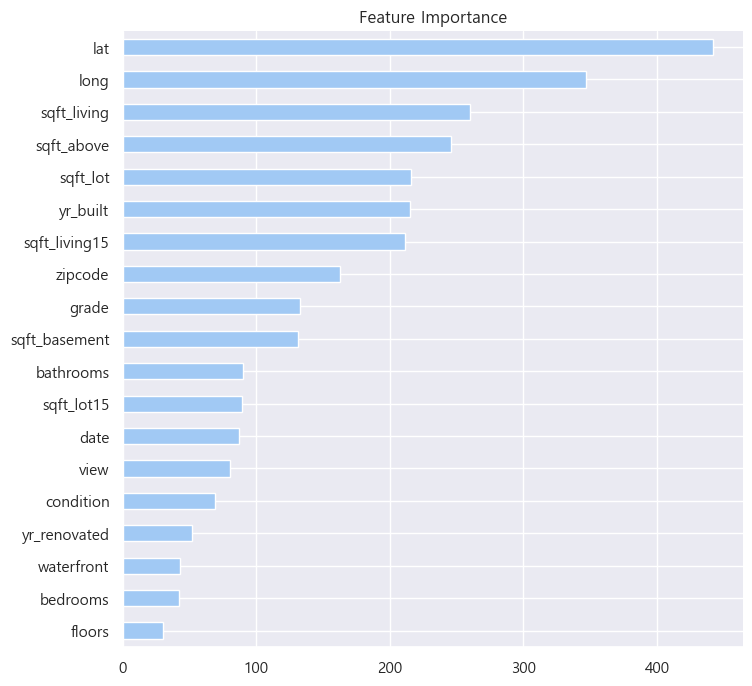

In [298]:
# 출력결과 시각화
feat_import = pd.Series(lightgbm.feature_importances_, index=train.columns)
feat_import.sort_values(inplace=True,ascending=False)

ax =feat_import.plot(kind='barh', figsize=(8,8), align='center', title='Feature Importance')
ax.invert_yaxis()

In [299]:
train2 = train.drop(['floors', 'bedrooms','waterfront','yr_renovated','condition','bathrooms','date','view','sqft_lot15','grade'], axis=1)
test2 = test.drop(['floors', 'bedrooms','waterfront','yr_renovated','condition','bathrooms','date','view','sqft_lot15','grade'], axis=1)
print(train2.shape, test2.shape)

(15035, 9) (6468, 9)


In [300]:
LGBM = lightgbm.fit(train2, y)
y_pred = LGBM.predict(test2)
y_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 1946
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 9
[LightGBM] [Info] Start training from score 540682.653143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

array([ 563107.09452508,  410334.19106371, 1276477.44756899, ...,
        445953.50474169,  349946.88595219,  400542.93397423])

In [301]:
sub2 = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub2.to_csv('submission2.csv', index=False)

* Private score : 149691

In [302]:
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m.fit(x, y)

    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [303]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\김영준\PycharmProjects\aiffel_study\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\김영준\PycharmProjects\aiffel_study\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([ 533070.24047292,  456322.63531636, 1330097.88923259, ...,
        460267.96821409,  335695.4142372 ,  429288.22038956])

In [304]:
sub3 = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub3.to_csv('submission3.csv', index=False)

* Private score : 113439

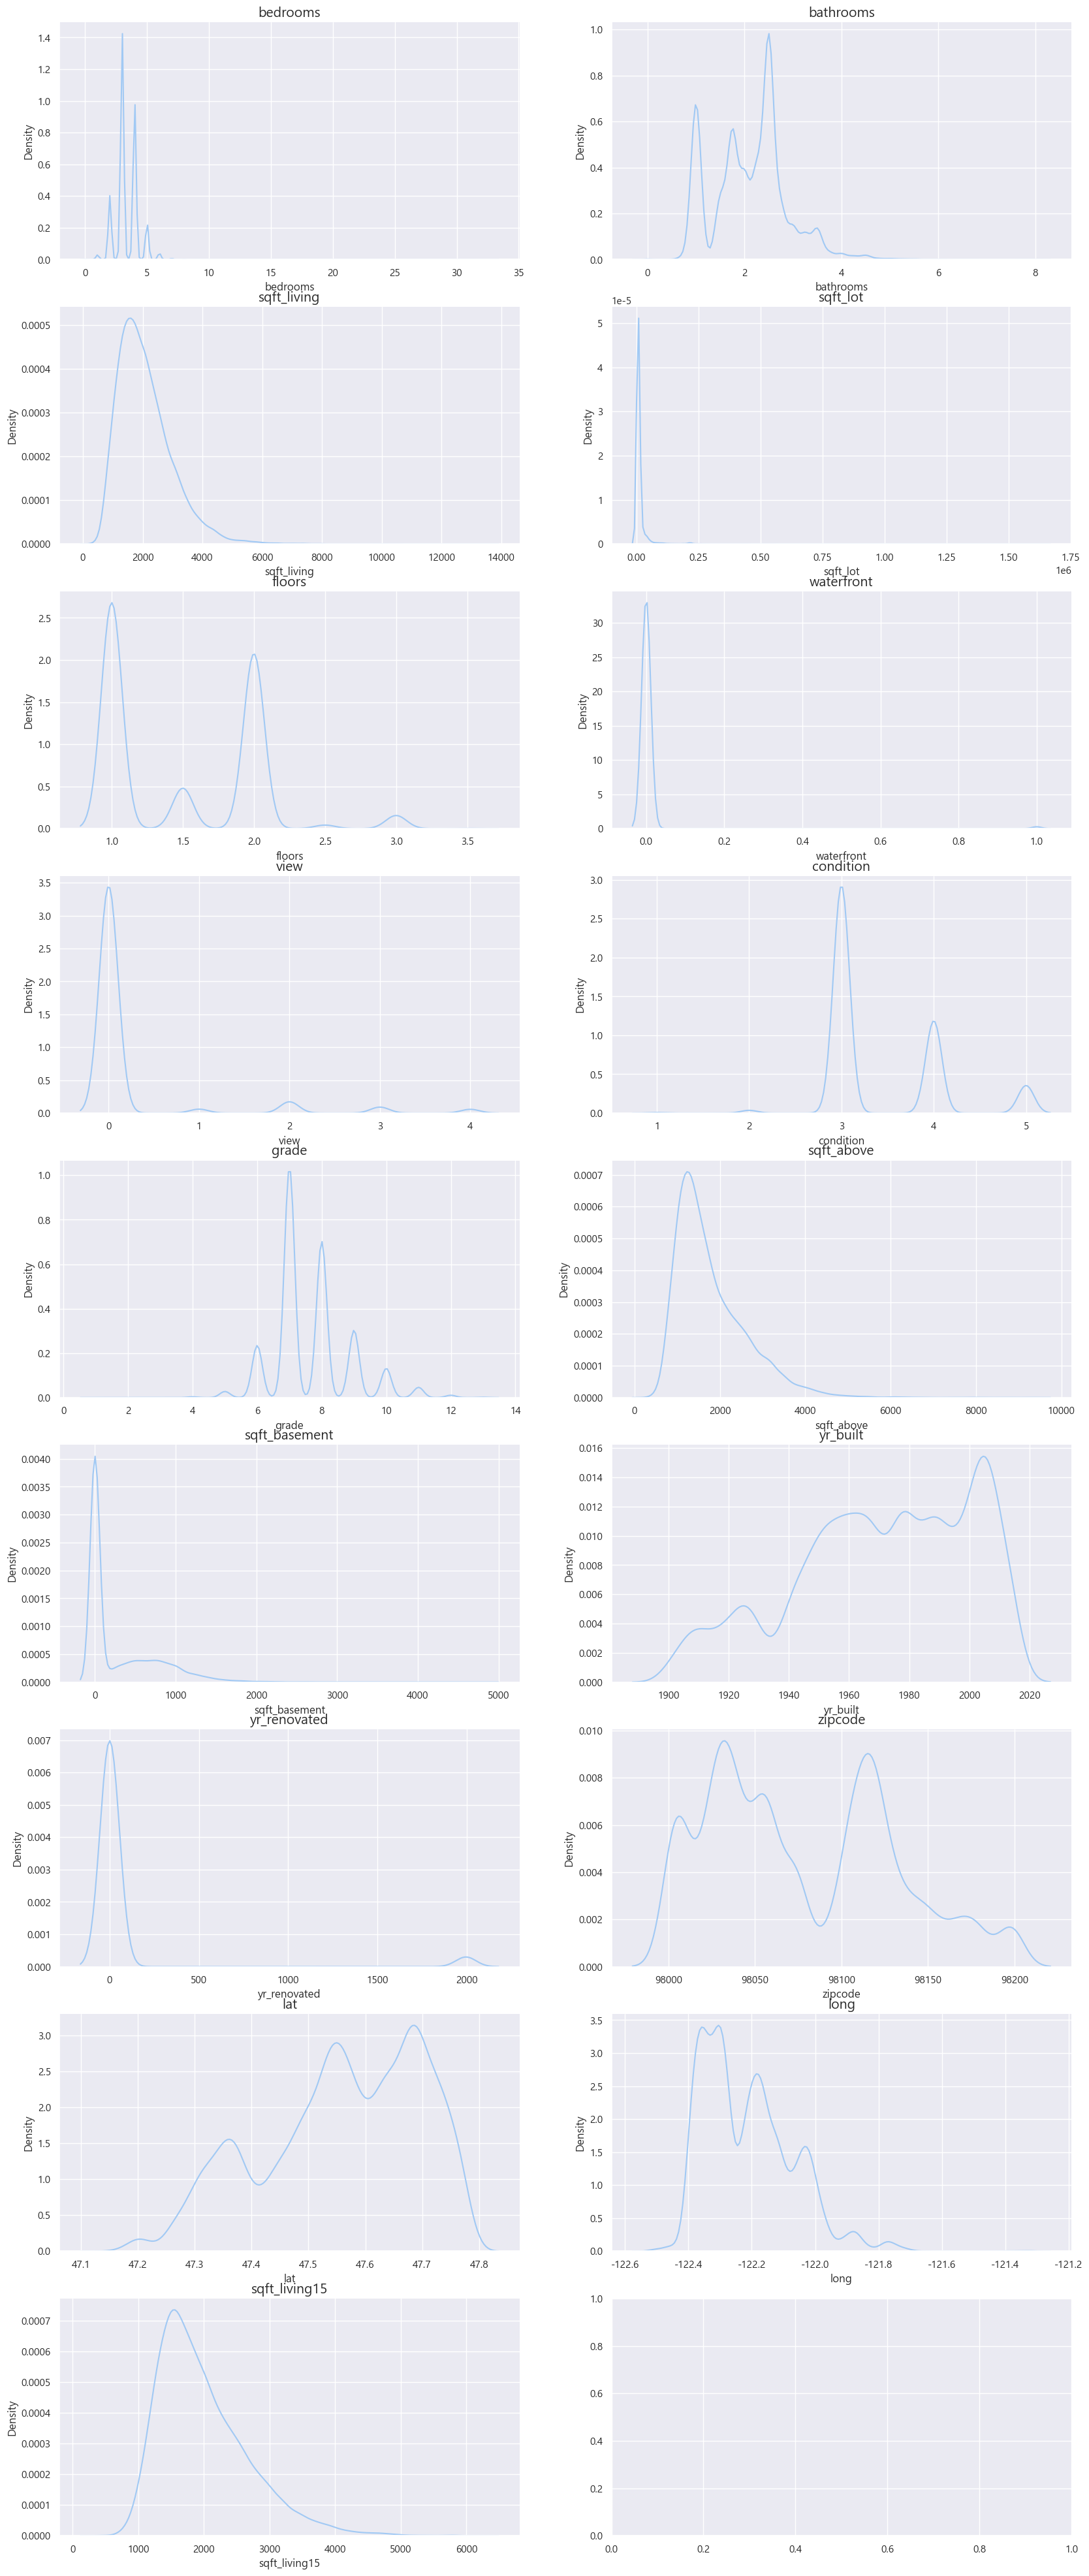

In [305]:
fig, ax = plt.subplots(9, 2, figsize=(20, 50))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 18 :
            break

In [306]:
skew_columns = ['bedrooms', 'sqft_living','sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

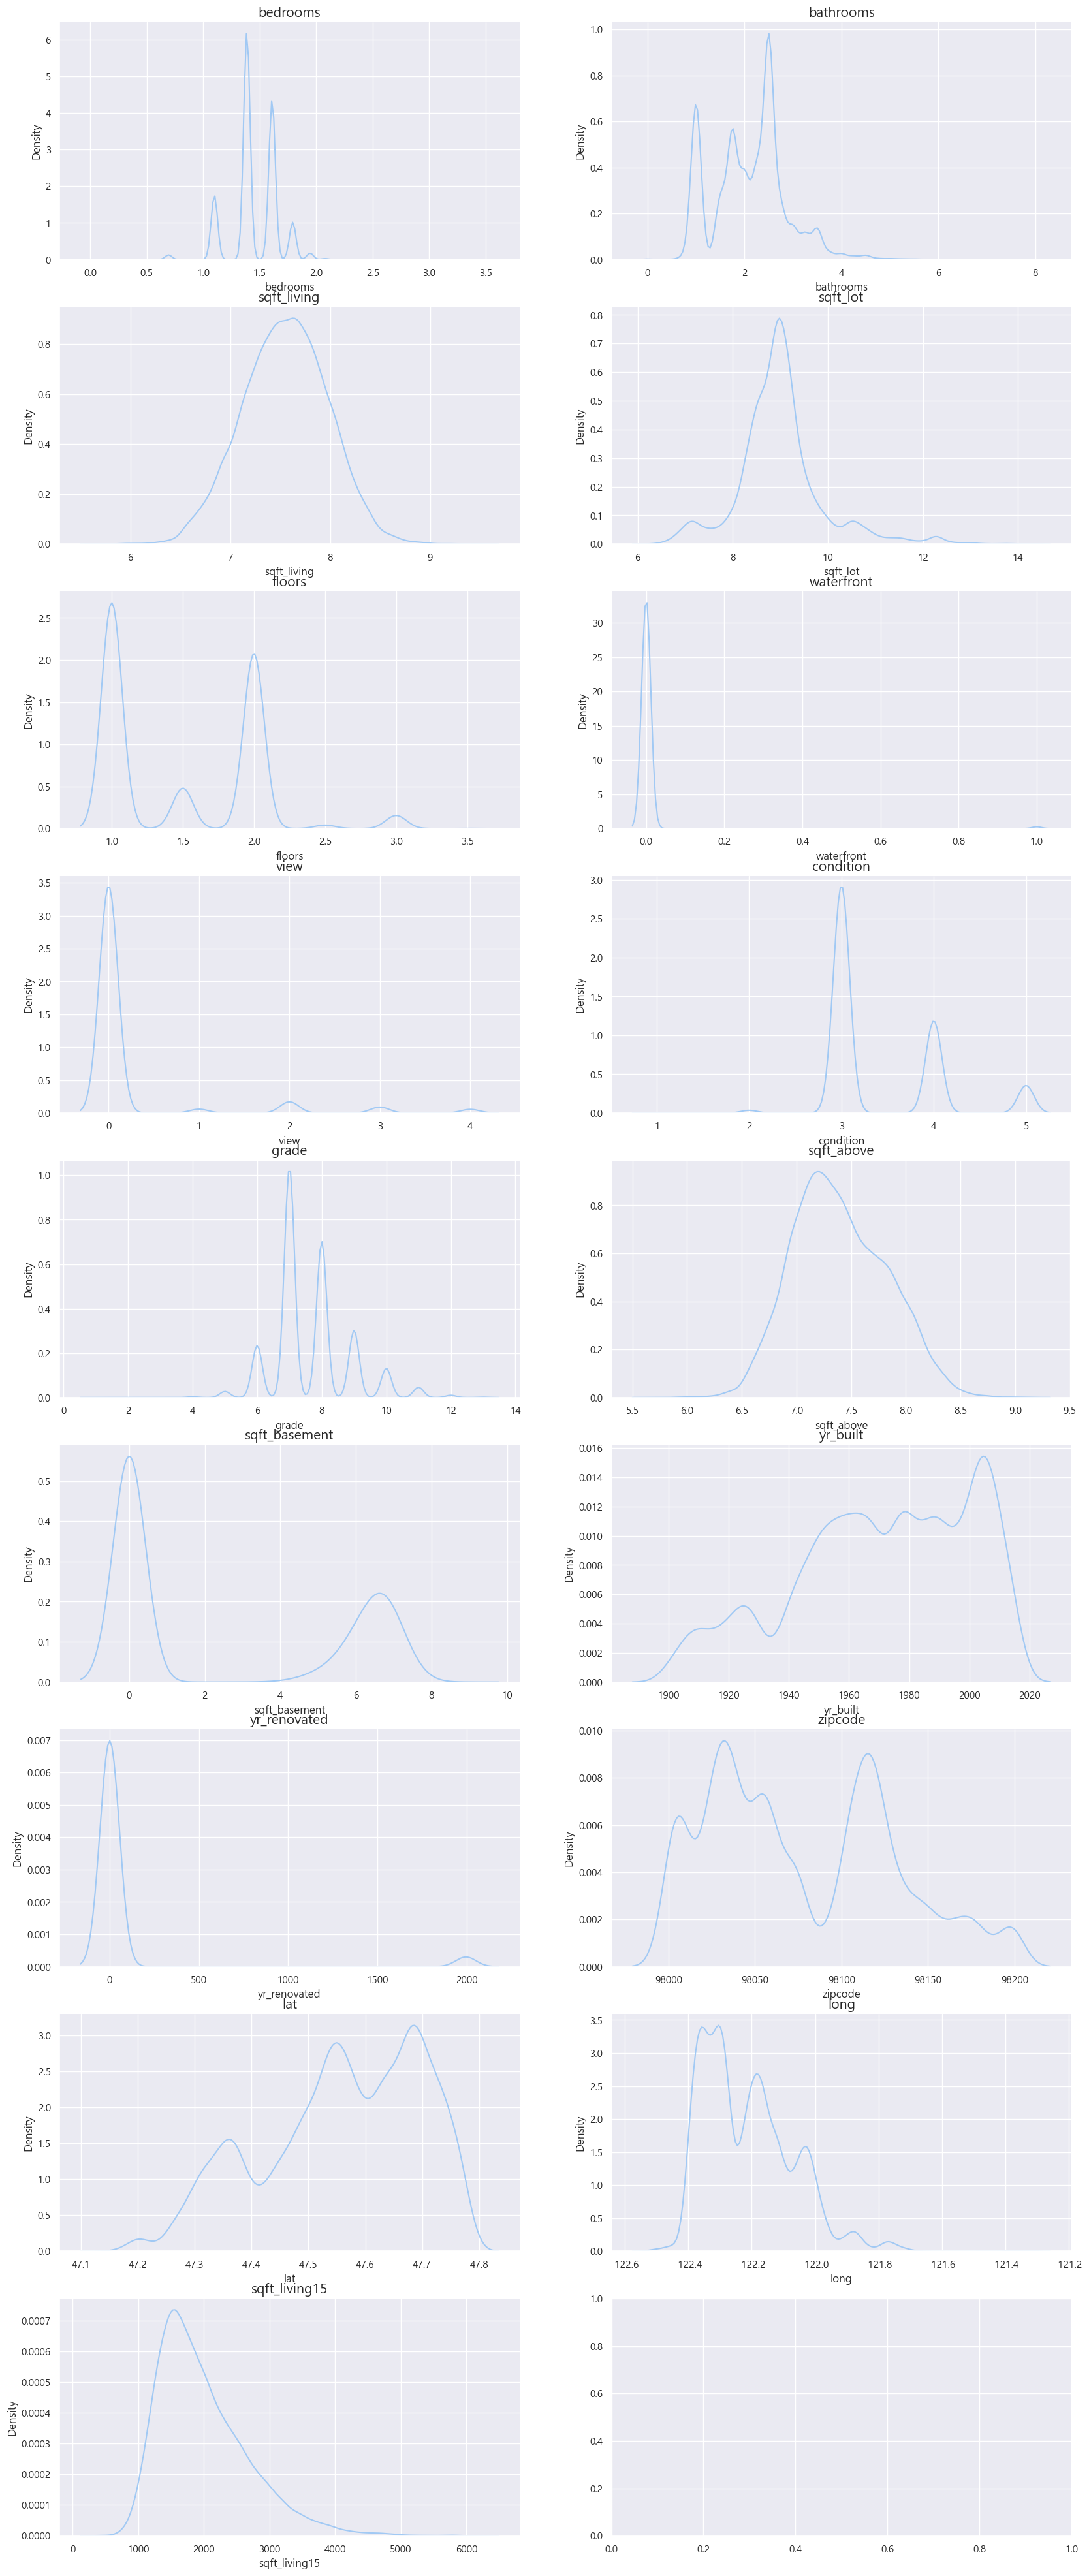

In [307]:
fig, ax = plt.subplots(9, 2, figsize=(20, 50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 18 :
            break

In [308]:
for i in [train, test]:
    for c in skew_columns:
        i[c] = np.log1p(i[c].values)

In [309]:
y2 = np.log1p(y)
y2

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [310]:
y_pred = AveragingBlending(models, train, y2, test)
z = np.expm1(y_pred)
z

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


C:\Users\김영준\PycharmProjects\aiffel_study\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\김영준\PycharmProjects\aiffel_study\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([ 500762.63723664,  447254.3354769 , 1312572.04711165, ...,
        453022.93758419,  331017.16870617,  432856.65278764])

In [311]:
sub4 = pd.DataFrame(data={'id':sub_id,'price':z})
sub4.to_csv('submission4.csv', index=False)